<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/akila/task1_eda_and_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 Notebook for "LSTM"

## Imports and Setup

**Import the Libararies**

In [23]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Connecting to Google Drive

In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


### Reading data set files

In [3]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
bookings_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/bookings_train.csv')
tasks_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/tasks.csv')
staffing_data = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/staffing_train.csv')

bookings_data.head()

In [4]:
staffing_data.head()

date section_id  employees_on_duty  total_task_time_minutes
0  2021-01-01    SEC-001                  1               834.569483
1  2021-01-01    SEC-002                  4              1525.368990
2  2021-01-01    SEC-003                  2               662.095279
3  2021-01-01    SEC-004                  4              1499.112620
4  2021-01-01    SEC-005                  3              1238.533073

In [5]:
tasks_data.head()

task_id  task_name section_id  section_name
0  TASK-001        NaN    SEC-001           NaN
1  TASK-002        NaN    SEC-001           NaN
2  TASK-003        NaN    SEC-002           NaN
3  TASK-004        NaN    SEC-002           NaN
4  TASK-005        NaN    SEC-002           NaN

## EDA

### EDA of Bookings data

lets take a look at the columns and some of their values

In [6]:
bookings_data.head()

booking_id  citizen_id booking_date  \
0  f7b59ba3793fea61282cb02be2247cebd0a75306  4229044420   2021-01-01   
1  cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80  5389442635   2021-01-01   
2  0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8  2123783919   2021-01-01   
3  d4bf826153212fa325ad98b215668ab942365607  6359918966   2021-01-01   
4  ebb4c9687acbaf65376d8e379bd1341d1c15127e   178732202   2021-01-01   

  appointment_date appointment_time        check_in_time  \
0       2021-01-01            09:03  2021-01-01 09:11:00   
1       2021-01-01            09:12  2021-01-01 09:24:00   
2       2021-01-01            09:36  2021-01-01 09:29:00   
3       2021-01-01            09:45  2021-01-01 10:07:00   
4       2021-01-01            10:12  2021-01-01 10:26:00   

                  check_out_time   task_id  num_documents  queue_number  \
0  2021-01-01 09:48:15.166353269  TASK-002              0             2   
1  2021-01-01 10:24:12.189261137  TASK-001              1             1   
2  2021-01-01 10:26:48.802260864  TASK-002              1             6   
3  2021-01-01 11:00:13.485642822  TASK-001              1             4   
4  2021-01-01 11:54:53.260180213  TASK-002              1             8   

   satisfaction_rating  
0                    4  
1                    4  
2                    5  
3                    4  
4                    3

In [7]:
bookings_data.describe()

citizen_id  num_documents   queue_number  satisfaction_rating
count  2.036930e+05  203693.000000  203693.000000        203693.000000
mean   4.996145e+09       2.436790       9.310511             4.187277
std    2.880985e+09       1.734511       8.245711             0.463539
min    4.318100e+04       0.000000       1.000000             3.000000
25%    2.504323e+09       1.000000       3.000000             4.000000
50%    4.995536e+09       2.000000       7.000000             4.000000
75%    7.491514e+09       3.000000      13.000000             4.000000
max    9.999975e+09      14.000000     133.000000             5.000000

removing unnecessary columns. We wont need the num_documents, queue_number and satisfication_rating because these data wont be provided as input from the test datasets. We need the checkin and checkout times because they will be to calculate the actual target value (the thing to be predicted) for task 1.

In [8]:
bookings_data = bookings_data.drop(['num_documents','queue_number','satisfaction_rating'],axis=1)

now lets look at the new table headers again.

In [9]:
bookings_data.head()

booking_id  citizen_id booking_date  \
0  f7b59ba3793fea61282cb02be2247cebd0a75306  4229044420   2021-01-01   
1  cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80  5389442635   2021-01-01   
2  0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8  2123783919   2021-01-01   
3  d4bf826153212fa325ad98b215668ab942365607  6359918966   2021-01-01   
4  ebb4c9687acbaf65376d8e379bd1341d1c15127e   178732202   2021-01-01   

  appointment_date appointment_time        check_in_time  \
0       2021-01-01            09:03  2021-01-01 09:11:00   
1       2021-01-01            09:12  2021-01-01 09:24:00   
2       2021-01-01            09:36  2021-01-01 09:29:00   
3       2021-01-01            09:45  2021-01-01 10:07:00   
4       2021-01-01            10:12  2021-01-01 10:26:00   

                  check_out_time   task_id  
0  2021-01-01 09:48:15.166353269  TASK-002  
1  2021-01-01 10:24:12.189261137  TASK-001  
2  2021-01-01 10:26:48.802260864  TASK-002  
3  2021-01-01 11:00:13.485642822  TASK-001  
4  2021-01-01 11:54:53.260180213  TASK-002

lets get a better idea of how null values have been distributed amoung the columns

In [10]:
bookings_data.isna().sum()

booking_id             0
citizen_id             0
booking_date           0
appointment_date       0
appointment_time       0
check_in_time       6092
check_out_time      6092
task_id                0
dtype: int64

Now, to see how the null distribution is like task-wise we will plot the following

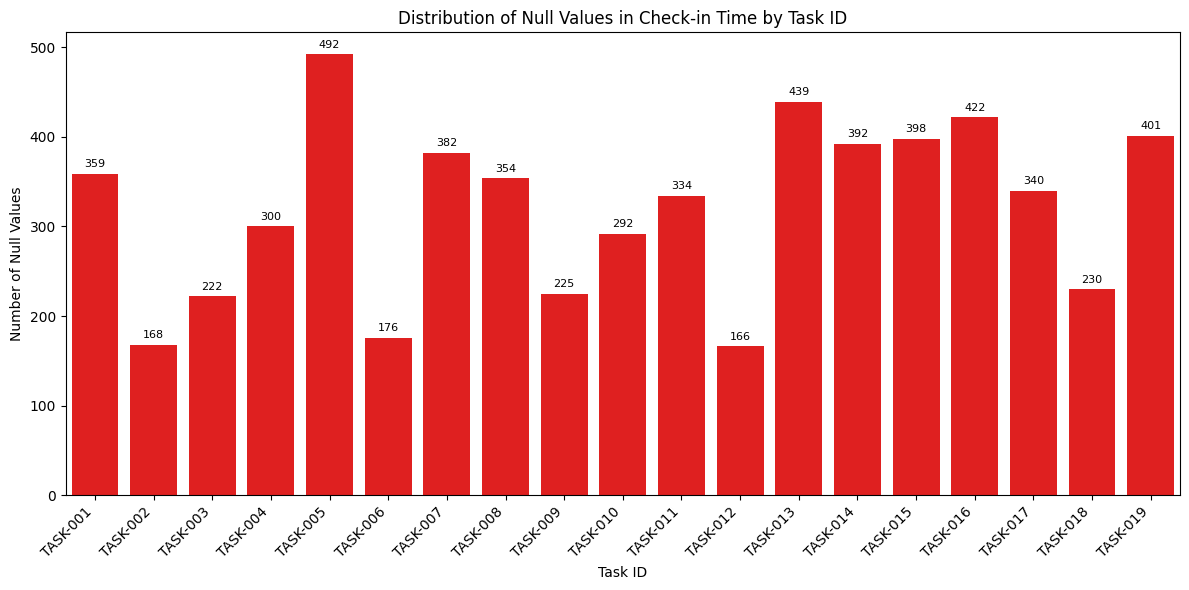

In [11]:
# Group by task_id and count null values in 'check_in_time'
null_counts_by_task = bookings_data.groupby('task_id')['check_in_time'].apply(lambda x: x.isnull().sum())

# Plot the distribution of null values by task_id
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=null_counts_by_task.index, y=null_counts_by_task.values, color='red')
plt.title('Distribution of Null Values in Check-in Time by Task ID')
plt.xlabel('Task ID')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')

# Add the count of null values above each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

now lets see how this looks like when comaparing with the total number of records per task

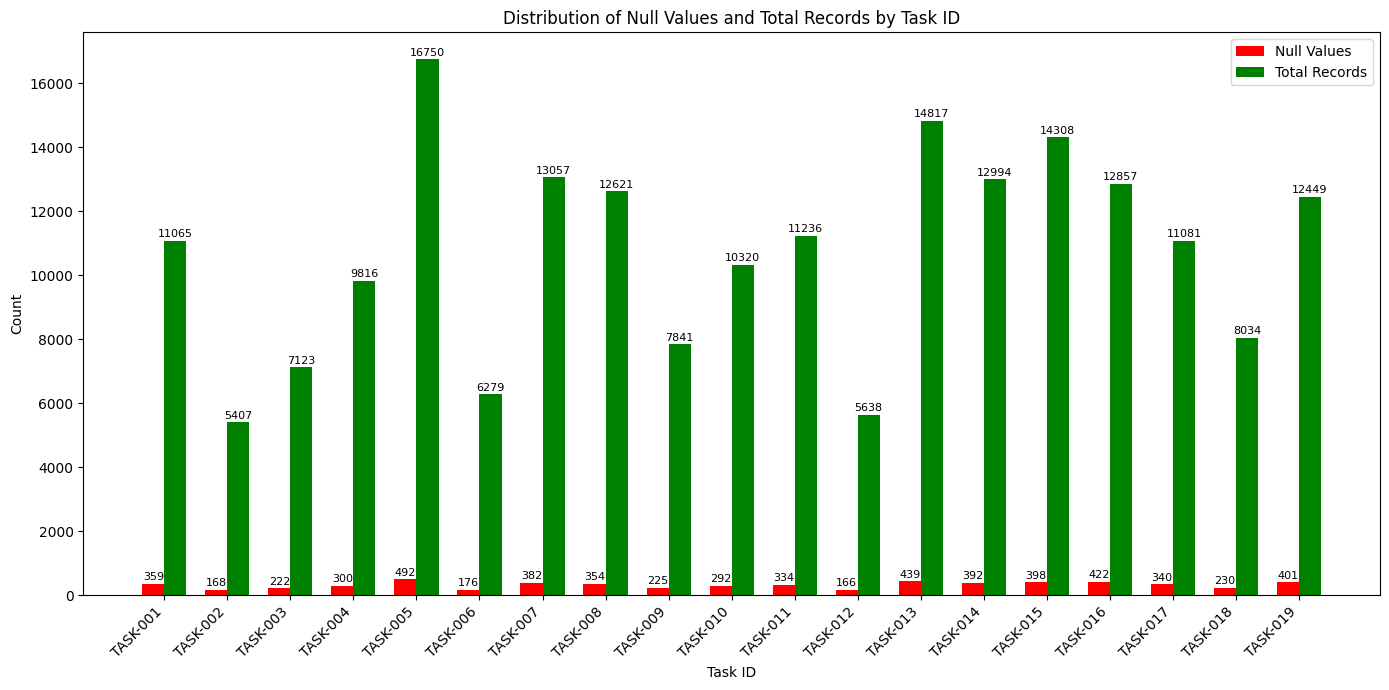

In [12]:
# Group by task_id and count null values in 'check_in_time'
null_counts_by_task = bookings_data.groupby('task_id')['check_in_time'].apply(lambda x: x.isnull().sum())

# Group by task_id and count total records
total_counts_by_task = bookings_data.groupby('task_id').size()

# Combine the data for plotting
combined_counts = pd.DataFrame({
    'Null Values': null_counts_by_task,
    'Total Records': total_counts_by_task
})

# Plot the distribution of null values and total records by task_id
plt.figure(figsize=(14, 7))
bar_width = 0.35
index = range(len(combined_counts.index))

bars1 = plt.bar(index, combined_counts['Null Values'], bar_width, label='Null Values', color='red')
bars2 = plt.bar([i + bar_width for i in index], combined_counts['Total Records'], bar_width, label='Total Records', color='green')

plt.xlabel('Task ID')
plt.ylabel('Count')
plt.title('Distribution of Null Values and Total Records by Task ID')
plt.xticks([i + bar_width/2 for i in index], combined_counts.index, rotation=45, ha='right')
plt.legend()

# Add the count of null values above each red bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=8)

# Add the total number of records above each green bar
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Data Preprocessing

### Rearrangement and processing of columns

the appointment_time column will be renamed as time as this is the column that is present in the test dataset and it keeps things simple. Next the check_in_time and the check_out_time have to be combined to get a single column called true_processing_time_minutes. the task_id will remain the same. the appointment_date will be changed to date. These changes will make it easier for testing and training purposes. Also the citizen_id and booking_id columns will be removed so as to not have the model misunderstand that these columns actually have an effect.

In [13]:
# Create a copy to avoid modifying the original DataFrame
edited_bookings_data = bookings_data.copy()

# Rename columns
edited_bookings_data = edited_bookings_data.rename(columns={
    'appointment_time': 'time',
    'appointment_date': 'date'
})

# Convert time columns to datetime objects
edited_bookings_data['check_in_time'] = pd.to_datetime(edited_bookings_data['check_in_time'])
edited_bookings_data['check_out_time'] = pd.to_datetime(edited_bookings_data['check_out_time'])

# Calculate the time difference in minutes, handling potential NaT values
edited_bookings_data['true_processing_time_minutes'] = (edited_bookings_data['check_out_time'] - edited_bookings_data['check_in_time']).dt.total_seconds() / 60

# Drop the original time columns and the requested columns
edited_bookings_data = edited_bookings_data.drop(['check_in_time', 'check_out_time', 'booking_date', 'citizen_id', 'booking_id'], axis=1)

# Display the first few rows of the new DataFrame
display(edited_bookings_data.head())

date   time   task_id  true_processing_time_minutes
0  2021-01-01  09:03  TASK-002                     37.252773
1  2021-01-01  09:12  TASK-001                     60.203154
2  2021-01-01  09:36  TASK-002                     57.813371
3  2021-01-01  09:45  TASK-001                     53.224761
4  2021-01-01  10:12  TASK-002                     88.887670

### Dataset seperation according to task_id

The number of records per task is as follows.

In [14]:
task_counts = bookings_data.groupby("task_id").size().reset_index(name="count")
task_counts

task_id  count
0   TASK-001  11065
1   TASK-002   5407
2   TASK-003   7123
3   TASK-004   9816
4   TASK-005  16750
5   TASK-006   6279
6   TASK-007  13057
7   TASK-008  12621
8   TASK-009   7841
9   TASK-010  10320
10  TASK-011  11236
11  TASK-012   5638
12  TASK-013  14817
13  TASK-014  12994
14  TASK-015  14308
15  TASK-016  12857
16  TASK-017  11081
17  TASK-018   8034
18  TASK-019  12449

As you can see the minimum number of records per task is 5407. So we have plenty of data to workwith.

Therefore, the plan is to train 19 different models to solve Task 1 to get the best results possible per task, and so the dataset will be split into 19 datasets.

In [15]:
task_1_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-001'].copy()
task_2_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-002'].copy()
task_3_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-003'].copy()
task_4_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-004'].copy()
task_5_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-005'].copy()
task_6_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-006'].copy()
task_7_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-007'].copy()
task_8_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-008'].copy()
task_9_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-009'].copy()
task_10_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-010'].copy()
task_11_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-011'].copy()
task_12_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-012'].copy()
task_13_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-013'].copy()
task_14_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-014'].copy()
task_15_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-015'].copy()
task_16_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-016'].copy()
task_17_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-017'].copy()
task_18_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-018'].copy()
task_19_data = edited_bookings_data[edited_bookings_data['task_id'] == 'TASK-019'].copy()

lets verify whether the split worked

In [16]:
task_1_data.head()

date   time   task_id  true_processing_time_minutes
1    2021-01-01  09:12  TASK-001                     60.203154
3    2021-01-01  09:45  TASK-001                     53.224761
7    2021-01-01  10:29  TASK-001                     58.550172
8    2021-01-01  10:38  TASK-001                     60.147629
198  2021-01-04  09:13  TASK-001                     58.843320

now lets save the 19 datasets into 19 files for future use

In [17]:
# List of all task dataframes
task_dataframes = [
    task_1_data, task_2_data, task_3_data, task_4_data, task_5_data,
    task_6_data, task_7_data, task_8_data, task_9_data, task_10_data,
    task_11_data, task_12_data, task_13_data, task_14_data, task_15_data,
    task_16_data, task_17_data, task_18_data, task_19_data
]

# Drop rows with null values in 'true_processing_time_minutes' for each dataframe
for i, df in enumerate(task_dataframes):
    initial_rows = df.shape[0]
    task_dataframes[i] = df.dropna(subset=['true_processing_time_minutes']).copy()
    rows_dropped = initial_rows - task_dataframes[i].shape[0]
    print(f"Task {i+1} Data: Dropped {rows_dropped} rows with null 'true_processing_time_minutes'. Remaining rows: {task_dataframes[i].shape[0]}")

# Reassign the modified dataframes to their original variable names
task_1_data = task_dataframes[0]
task_2_data = task_dataframes[1]
task_3_data = task_dataframes[2]
task_4_data = task_dataframes[3]
task_5_data = task_dataframes[4]
task_6_data = task_dataframes[5]
task_7_data = task_dataframes[6]
task_8_data = task_dataframes[7]
task_9_data = task_dataframes[8]
task_10_data = task_dataframes[9]
task_11_data = task_dataframes[10]
task_12_data = task_dataframes[11]
task_13_data = task_dataframes[12]
task_14_data = task_dataframes[13]
task_15_data = task_dataframes[14]
task_16_data = task_dataframes[15]
task_17_data = task_dataframes[16]
task_18_data = task_dataframes[17]
task_19_data = task_dataframes[18]

Task 1 Data: Dropped 359 rows with null 'true_processing_time_minutes'. Remaining rows: 10706
Task 2 Data: Dropped 168 rows with null 'true_processing_time_minutes'. Remaining rows: 5239
Task 3 Data: Dropped 222 rows with null 'true_processing_time_minutes'. Remaining rows: 6901
Task 4 Data: Dropped 300 rows with null 'true_processing_time_minutes'. Remaining rows: 9516
Task 5 Data: Dropped 492 rows with null 'true_processing_time_minutes'. Remaining rows: 16258
Task 6 Data: Dropped 176 rows with null 'true_processing_time_minutes'. Remaining rows: 6103
Task 7 Data: Dropped 382 rows with null 'true_processing_time_minutes'. Remaining rows: 12675
Task 8 Data: Dropped 354 rows with null 'true_processing_time_minutes'. Remaining rows: 12267
Task 9 Data: Dropped 225 rows with null 'true_processing_time_minutes'. Remaining rows: 7616
Task 10 Data: Dropped 292 rows with null 'true_processing_time_minutes'. Remaining rows: 10028
Task 11 Data: Dropped 334 rows with null 'true_processing_time_m

## Meging datasets into one (TODO)

In [18]:
sections_data = {
    "Vehicle Registration": [
        "Register new motor vehicles and issue registration numbers.",
        "Process the transfer of vehicle ownership."
    ],
    "Driver Licensing": [
        "Conduct theoretical and practical examinations for new driver's licenses.",
        "Process the renewal and reissue of driving licenses.",
        "Issue international driving permits.",
        "Manage license endorsements for different vehicle classes."
    ],
    "Vehicle Licensing & Revenue": [
        "Issue annual revenue licenses for all types of vehicles.",
        "Collect road taxes and other government levies on vehicles.",
        "Process refunds for overpaid taxes or surrendered licenses."
    ],
    "Technical Inspection & Fitness": [
        "Conduct vehicle inspections for roadworthiness and emissions.",
        "Maintain records of vehicle modifications and certifications.",
        "Issue vehicle fitness certificates (VFC) for commercial vehicles."
    ],
    "Public Information & Services": [
        "Provide access to online services for license and registration checks.",
        "Manage public inquiries and complaints related to traffic regulations.",
        "Publish reports and statistics on vehicle registrations."
    ],
    "Road Safety & Law Enforcement": [
        "Collaborate with law enforcement on vehicle-related legal matters.",
        "Maintain a database of traffic violations and demerit points for drivers.",
        "Develop and implement road safety awareness campaigns.",
        "Manage the suspension and revocation of driving licenses."
    ]
}

In [19]:
all_task_names = []
all_section_names = []

In [20]:
for section, tasks in sections_data.items():
    for task in tasks:
        all_task_names.append(task)
        all_section_names.append(section)

In [21]:
all_task_names

['Register new motor vehicles and issue registration numbers.',
 'Process the transfer of vehicle ownership.',
 "Conduct theoretical and practical examinations for new driver's licenses.",
 'Process the renewal and reissue of driving licenses.',
 'Issue international driving permits.',
 'Manage license endorsements for different vehicle classes.',
 'Issue annual revenue licenses for all types of vehicles.',
 'Collect road taxes and other government levies on vehicles.',
 'Process refunds for overpaid taxes or surrendered licenses.',
 'Conduct vehicle inspections for roadworthiness and emissions.',
 'Maintain records of vehicle modifications and certifications.',
 'Issue vehicle fitness certificates (VFC) for commercial vehicles.',
 'Provide access to online services for license and registration checks.',
 'Manage public inquiries and complaints related to traffic regulations.',
 'Publish reports and statistics on vehicle registrations.',
 'Collaborate with law enforcement on vehicle-re

In [22]:
all_section_names

['Vehicle Registration',
 'Vehicle Registration',
 'Driver Licensing',
 'Driver Licensing',
 'Driver Licensing',
 'Driver Licensing',
 'Vehicle Licensing & Revenue',
 'Vehicle Licensing & Revenue',
 'Vehicle Licensing & Revenue',
 'Technical Inspection & Fitness',
 'Technical Inspection & Fitness',
 'Technical Inspection & Fitness',
 'Public Information & Services',
 'Public Information & Services',
 'Public Information & Services',
 'Road Safety & Law Enforcement',
 'Road Safety & Law Enforcement',
 'Road Safety & Law Enforcement',
 'Road Safety & Law Enforcement']

Prepare List of Task DataFrames


In [24]:
task_dataframes = [
    task_1_data, task_2_data, task_3_data, task_4_data, task_5_data,
    task_6_data, task_7_data, task_8_data, task_9_data, task_10_data,
    task_11_data, task_12_data, task_13_data, task_14_data, task_15_data,
    task_16_data, task_17_data, task_18_data, task_19_data
]
results = []


Loop Over Each Task DataFrame to Train and Evaluate LSTM Model


=== Task-01 ===
Shape of X_test before reshape: (2142, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 8.20, RMSE: 10.38, R2: 0.07, Test MAPE: 15.07%, Test Accuracy: 84.93%


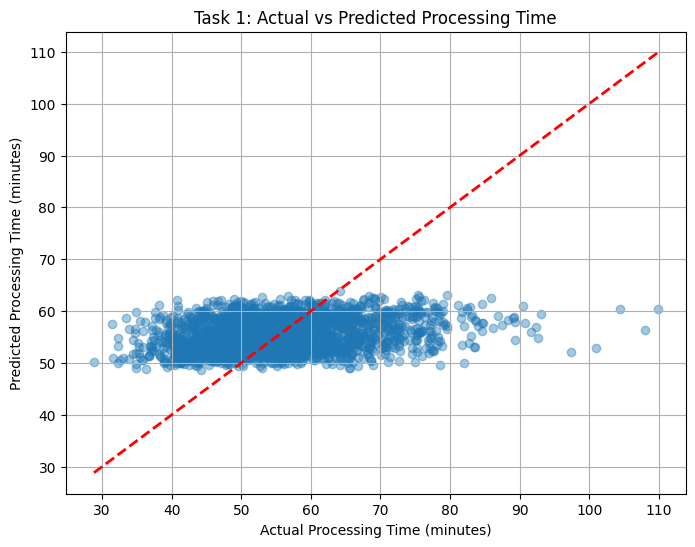

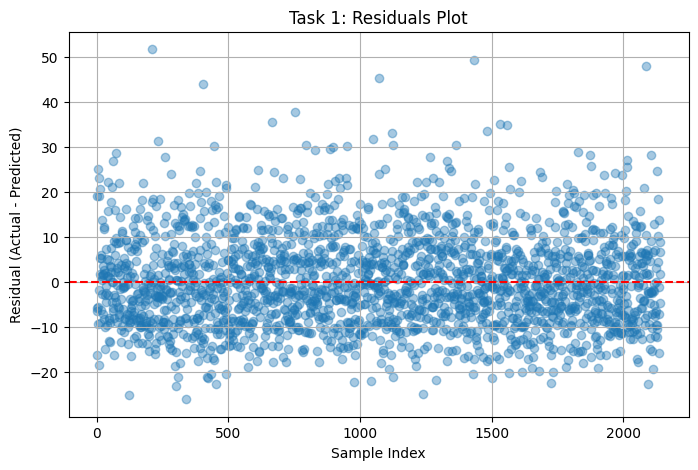


=== Task-02 ===
Shape of X_test before reshape: (1048, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MAE: 15.62, RMSE: 20.27, R2: 0.05, Test MAPE: 23.60%, Test Accuracy: 76.40%


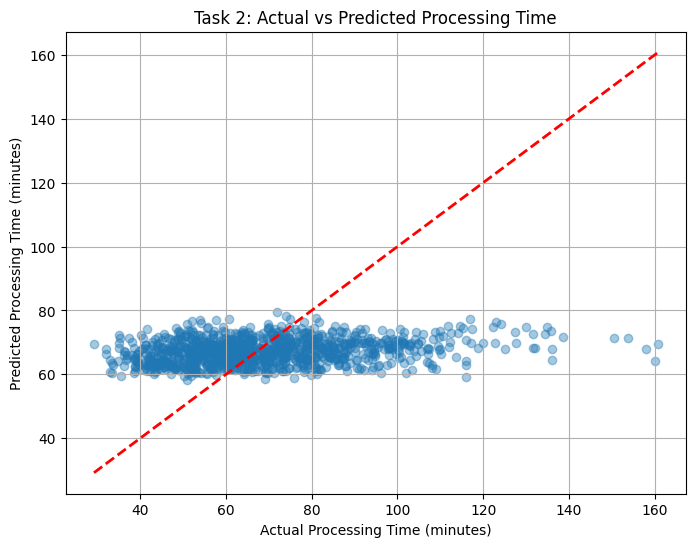

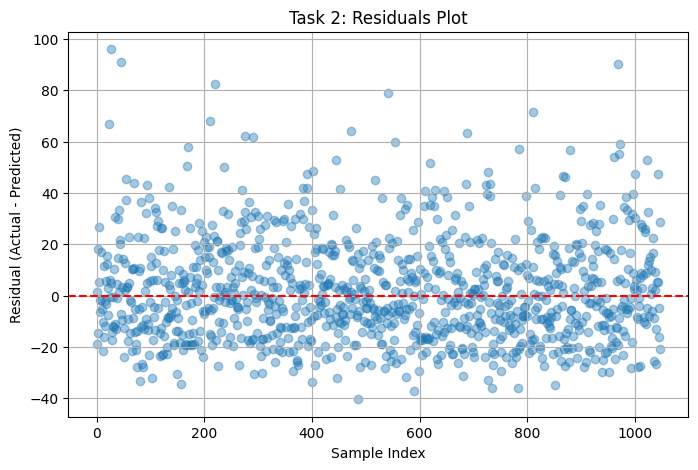


=== Task-03 ===
Shape of X_test before reshape: (1381, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 15.44, RMSE: 19.88, R2: 0.03, Test MAPE: 27.76%, Test Accuracy: 72.24%


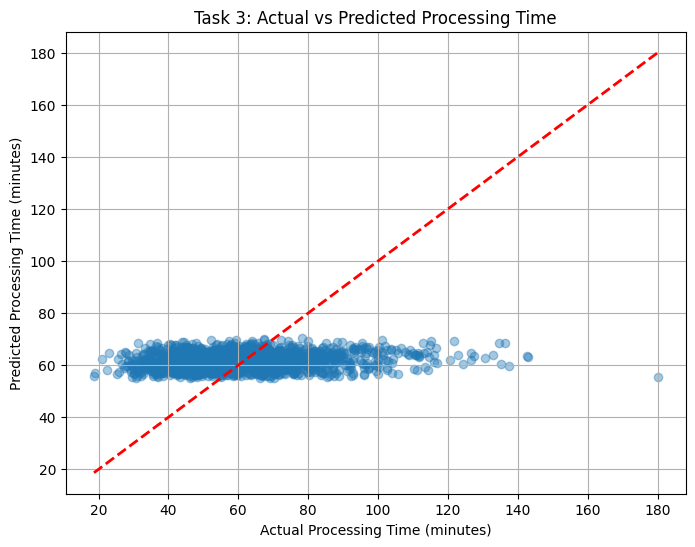

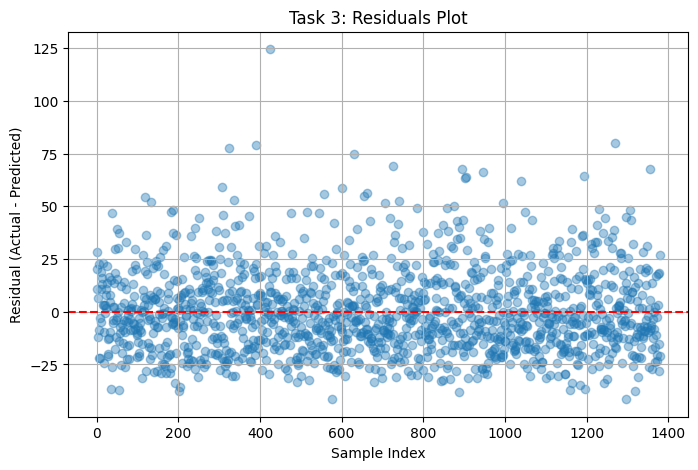


=== Task-04 ===
Shape of X_test before reshape: (1904, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 4.29, RMSE: 5.57, R2: 0.05, Test MAPE: 15.88%, Test Accuracy: 84.12%


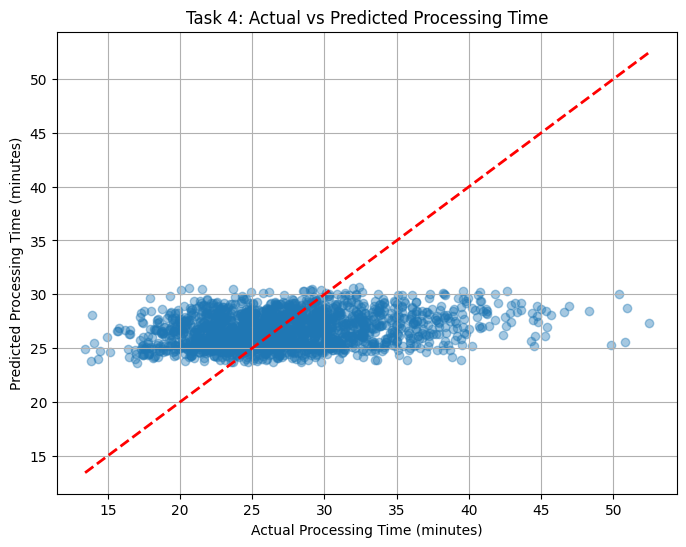

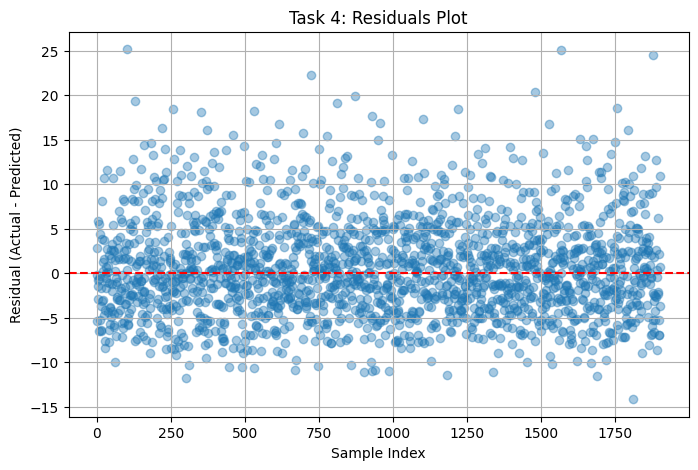


=== Task-05 ===
Shape of X_test before reshape: (3252, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 5.32, RMSE: 6.81, R2: 0.08, Test MAPE: 15.42%, Test Accuracy: 84.58%


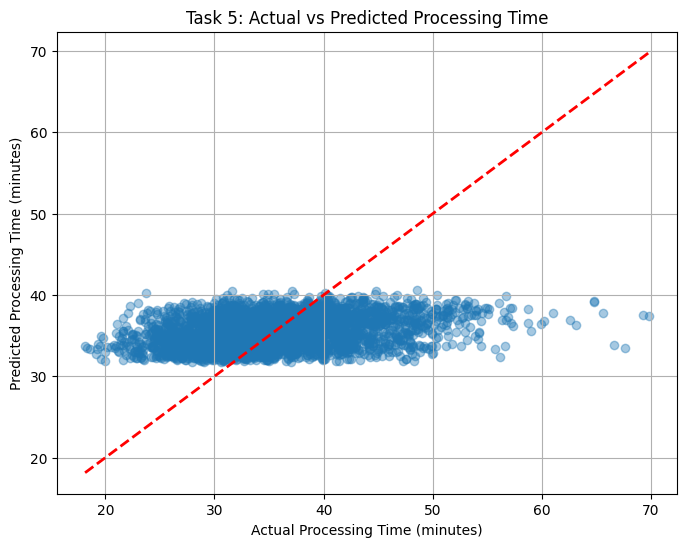

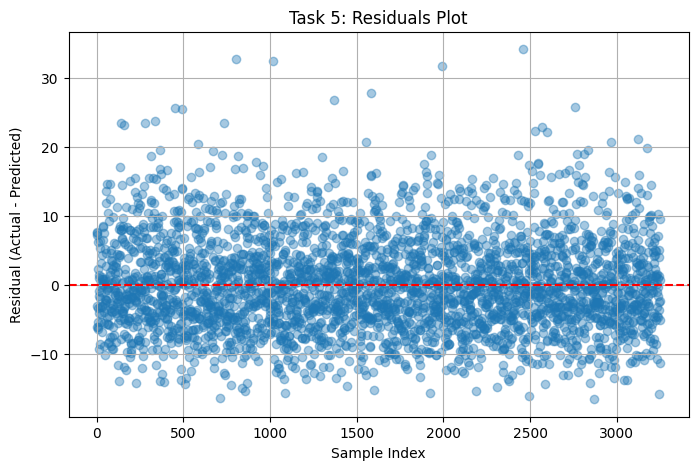


=== Task-06 ===
Shape of X_test before reshape: (1221, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 10.83, RMSE: 14.63, R2: 0.01, Test MAPE: 26.46%, Test Accuracy: 73.54%


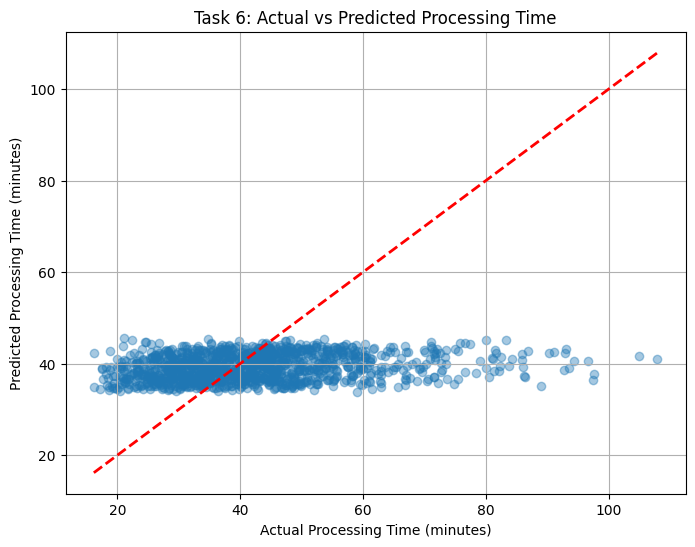

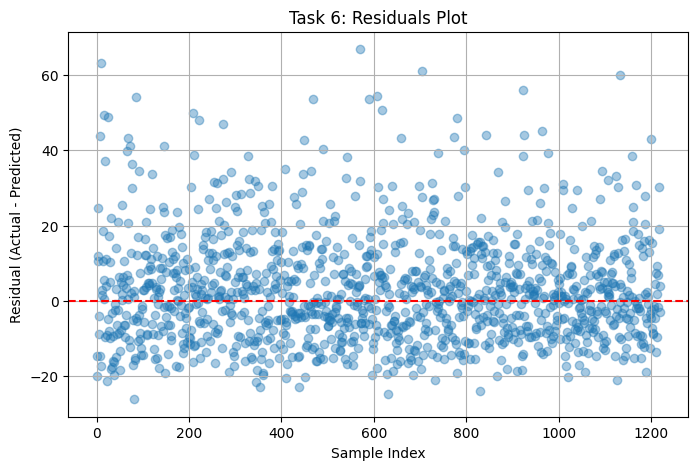


=== Task-07 ===
Shape of X_test before reshape: (2535, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 6.21, RMSE: 8.24, R2: -0.00, Test MAPE: 26.81%, Test Accuracy: 73.19%


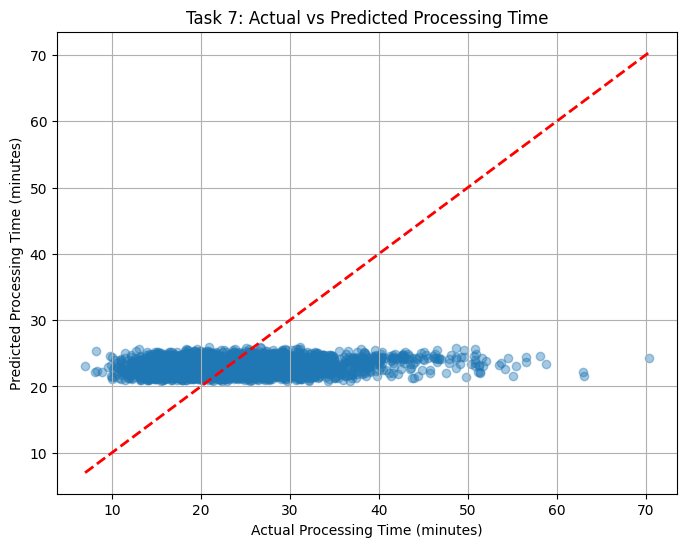

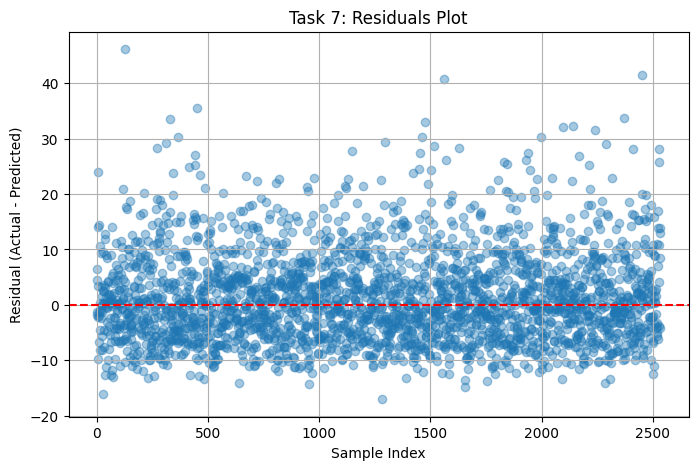


=== Task-08 ===
Shape of X_test before reshape: (2454, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 6.84, RMSE: 8.95, R2: 0.02, Test MAPE: 23.77%, Test Accuracy: 76.23%


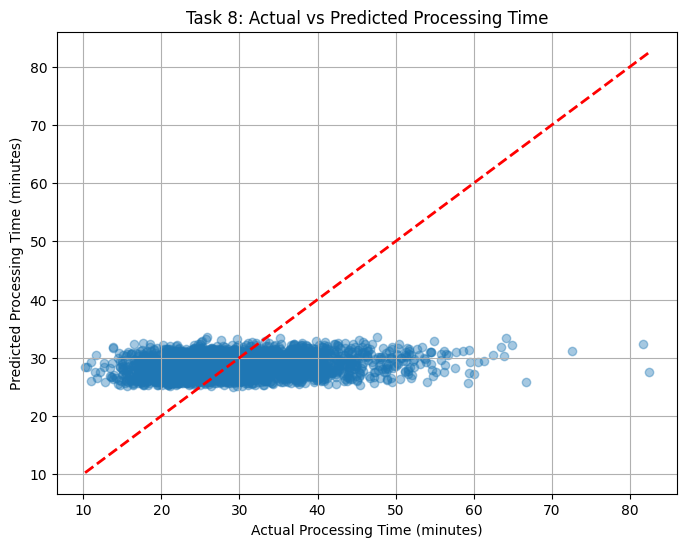

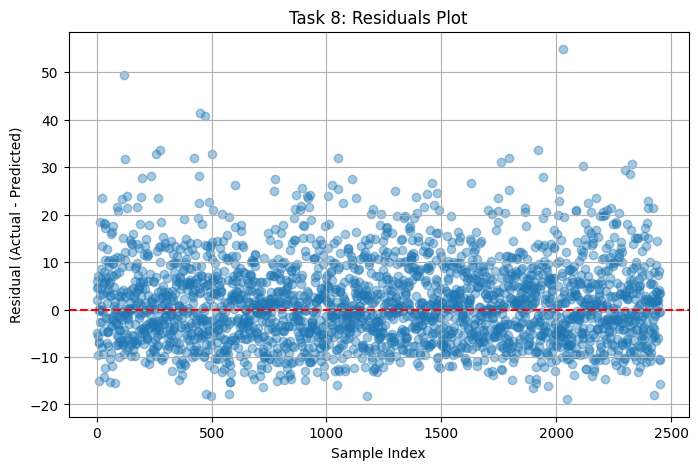


=== Task-09 ===
Shape of X_test before reshape: (1524, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 5.49, RMSE: 7.14, R2: 0.10, Test MAPE: 13.51%, Test Accuracy: 86.49%


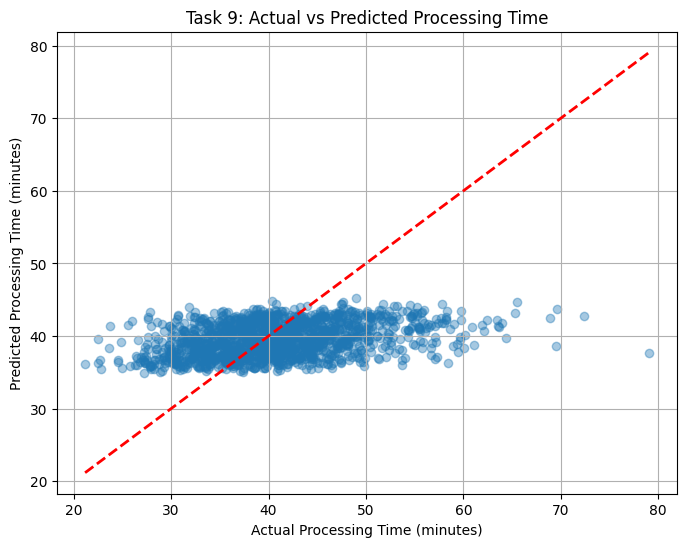

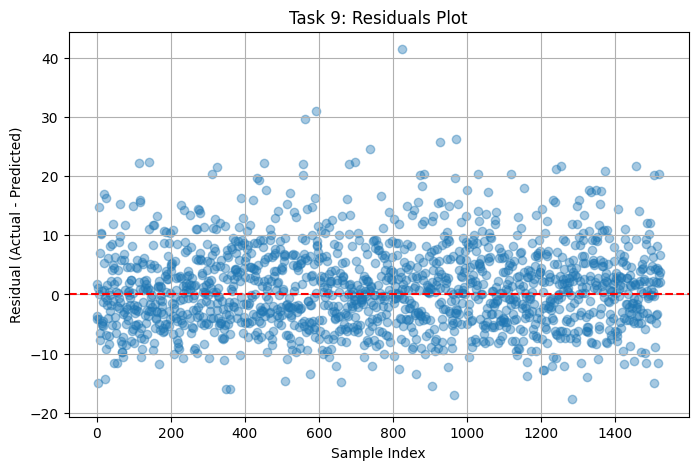


=== Task-10 ===
Shape of X_test before reshape: (2006, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 6.61, RMSE: 8.91, R2: 0.03, Test MAPE: 17.86%, Test Accuracy: 82.14%


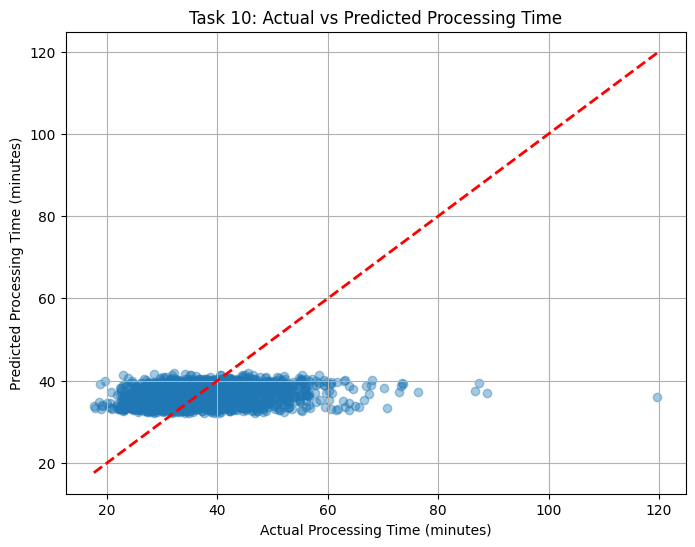

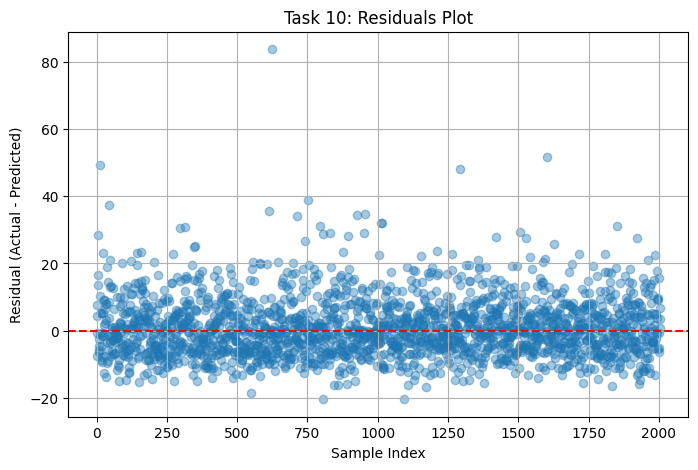


=== Task-11 ===
Shape of X_test before reshape: (2181, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 4.34, RMSE: 5.60, R2: 0.08, Test MAPE: 13.70%, Test Accuracy: 86.30%


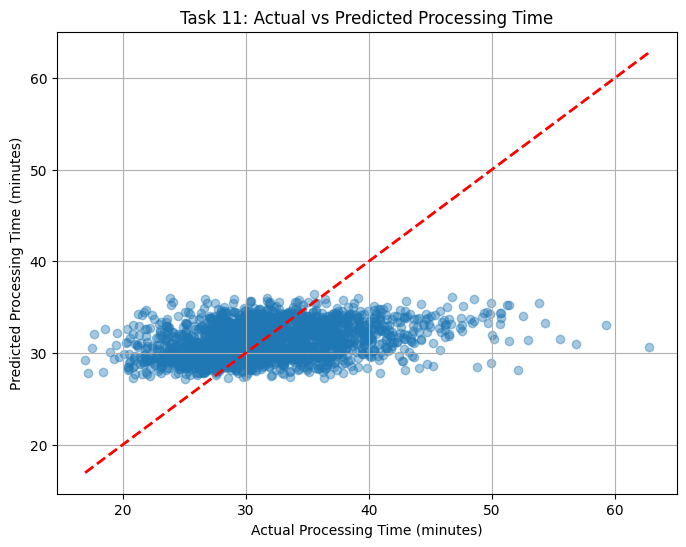

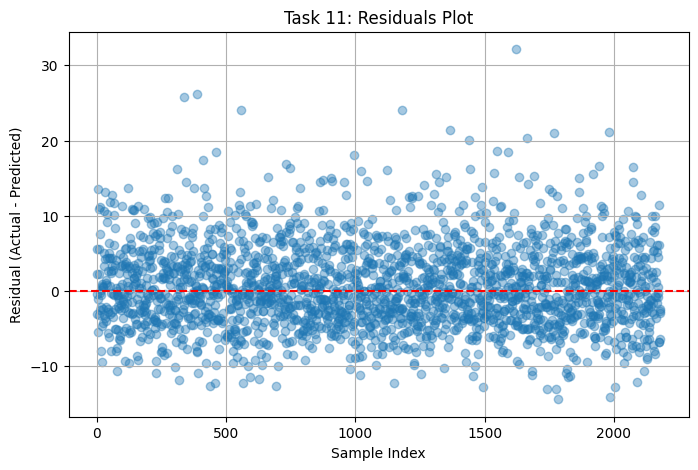


=== Task-12 ===
Shape of X_test before reshape: (1095, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MAE: 11.86, RMSE: 15.71, R2: 0.00, Test MAPE: 19.49%, Test Accuracy: 80.51%


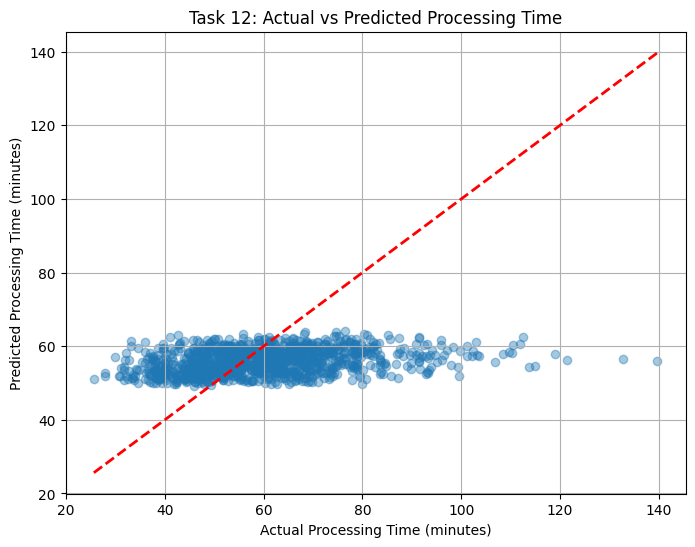

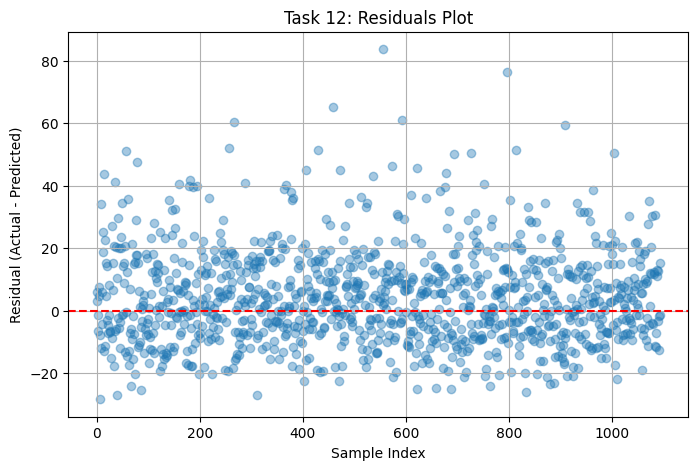


=== Task-13 ===
Shape of X_test before reshape: (2876, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 22.03, RMSE: 28.94, R2: -0.00, Test MAPE: 28.31%, Test Accuracy: 71.69%


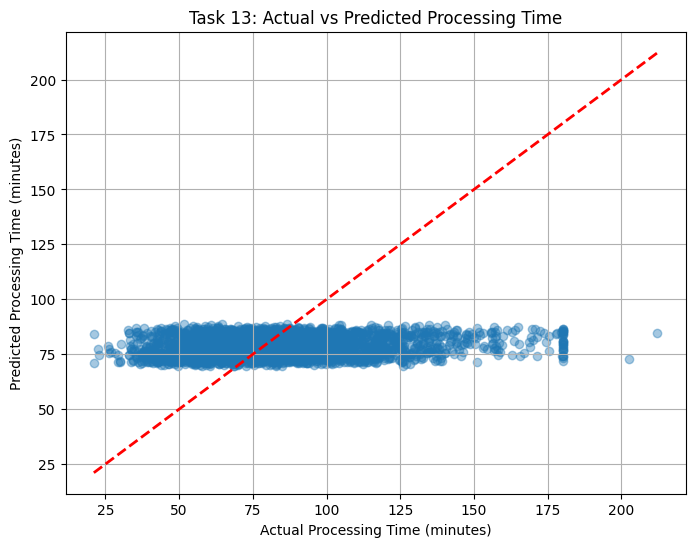

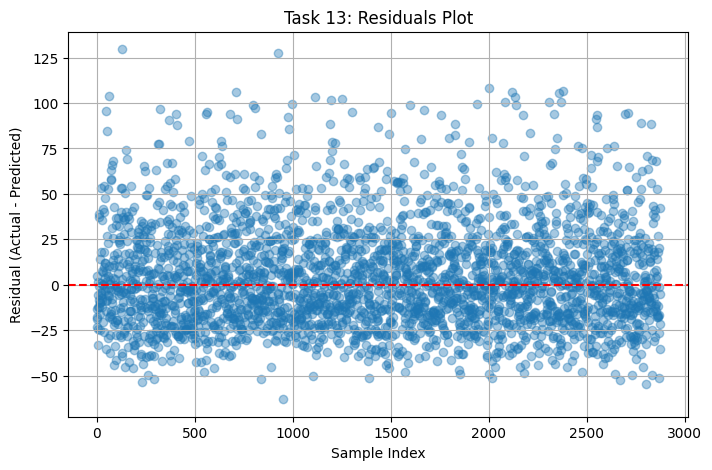


=== Task-14 ===
Shape of X_test before reshape: (2521, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE: 5.79, RMSE: 7.49, R2: 0.08, Test MAPE: 14.47%, Test Accuracy: 85.53%


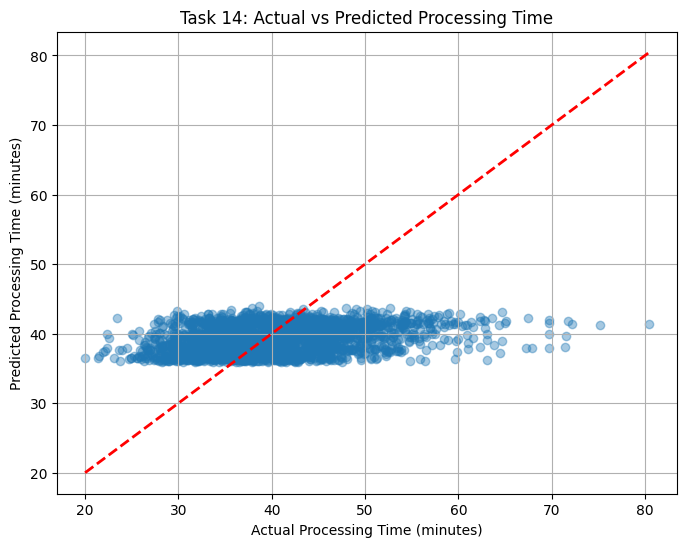

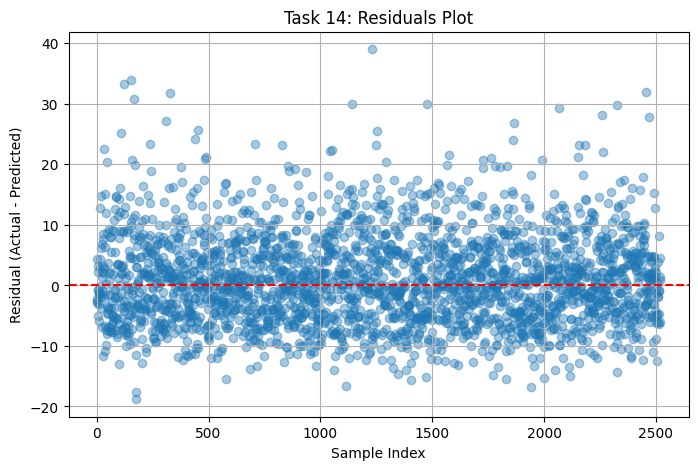


=== Task-15 ===
Shape of X_test before reshape: (2782, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 19.22, RMSE: 25.57, R2: -0.00, Test MAPE: 25.71%, Test Accuracy: 74.29%


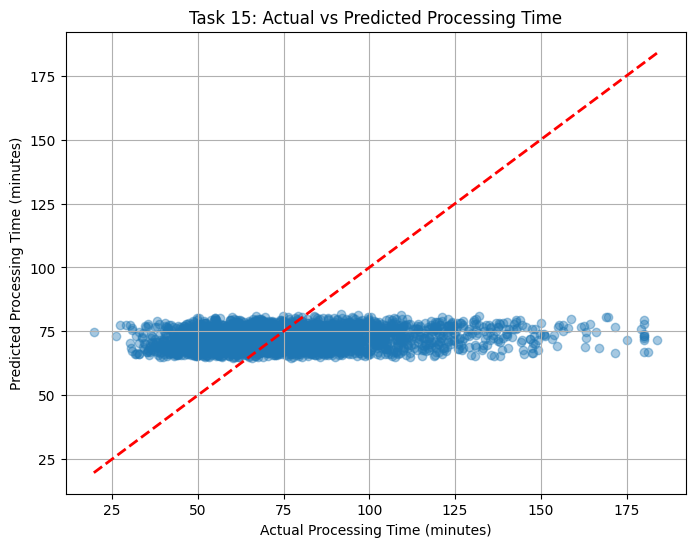

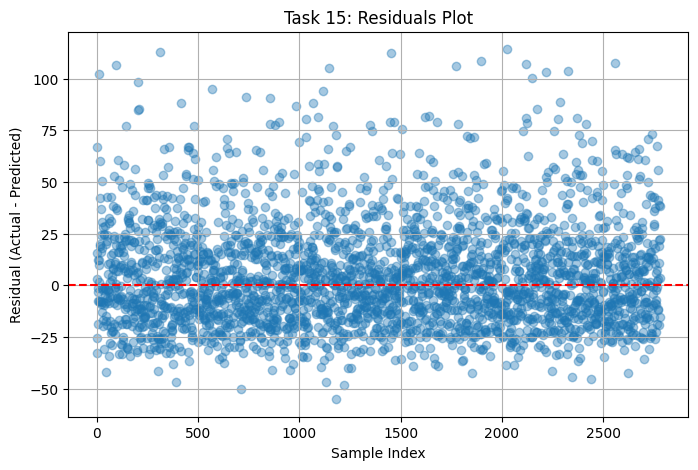


=== Task-16 ===
Shape of X_test before reshape: (2487, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 6.36, RMSE: 8.18, R2: 0.11, Test MAPE: 13.22%, Test Accuracy: 86.78%


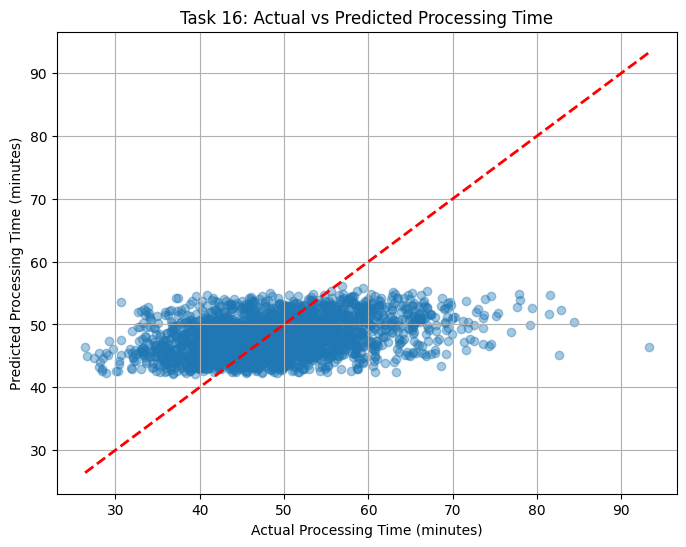

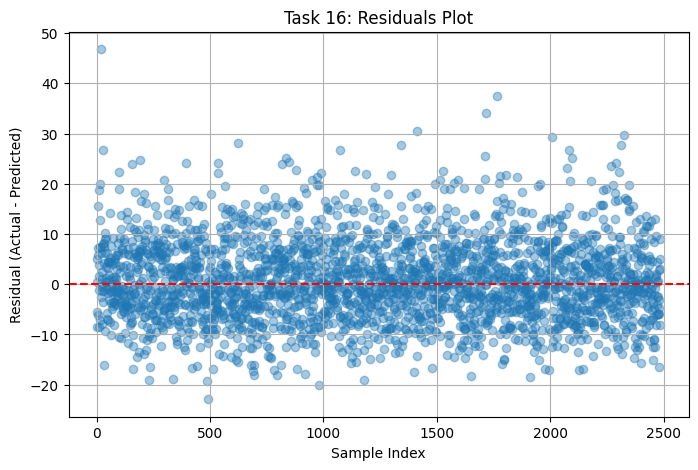


=== Task-17 ===
Shape of X_test before reshape: (2149, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 16.74, RMSE: 21.68, R2: 0.02, Test MAPE: 22.40%, Test Accuracy: 77.60%


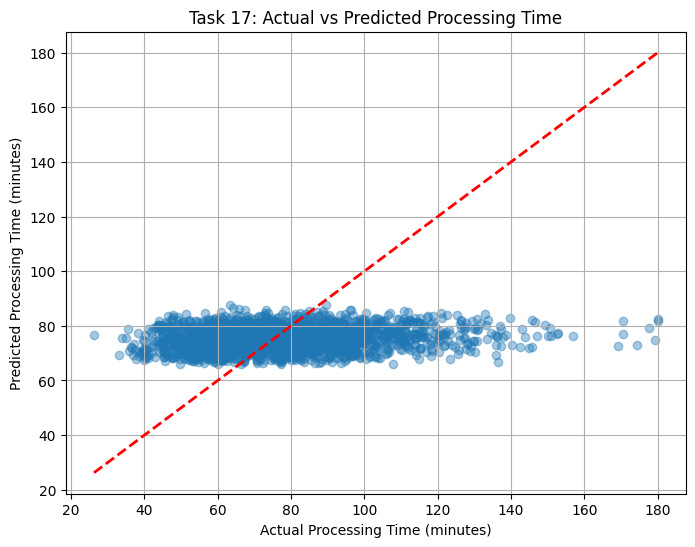

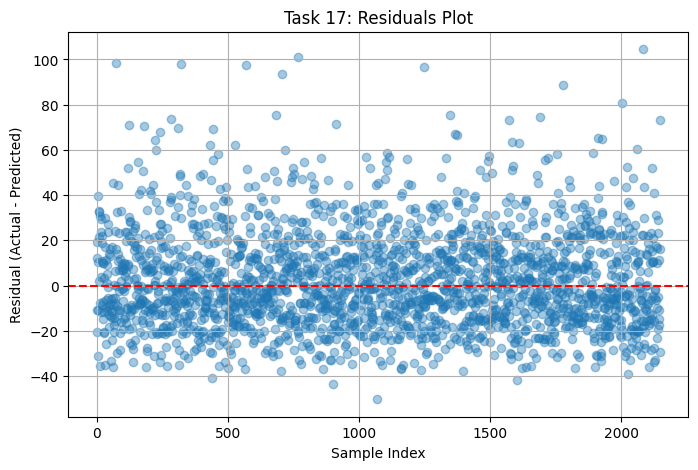


=== Task-18 ===
Shape of X_test before reshape: (1561, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MAE: 6.17, RMSE: 8.11, R2: -0.01, Test MAPE: 20.85%, Test Accuracy: 79.15%


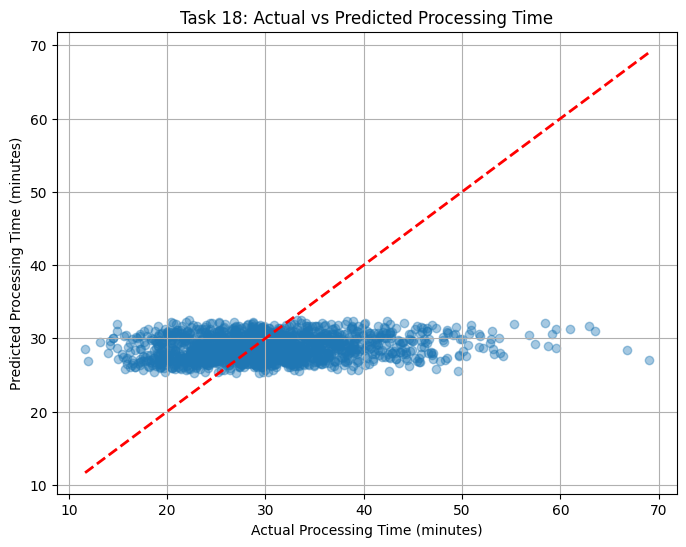

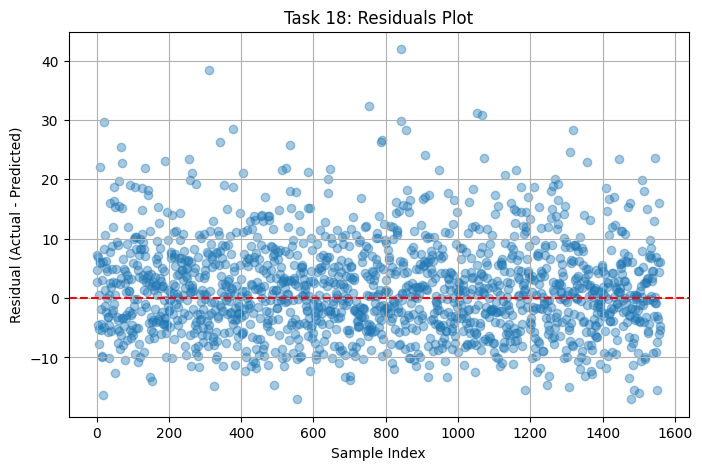


=== Task-19 ===
Shape of X_test before reshape: (2410, 6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 11.44, RMSE: 15.19, R2: 0.03, Test MAPE: 20.43%, Test Accuracy: 79.57%


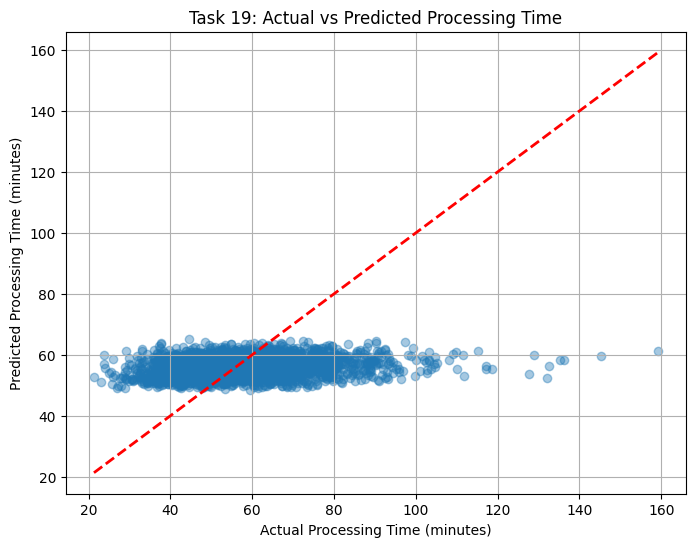

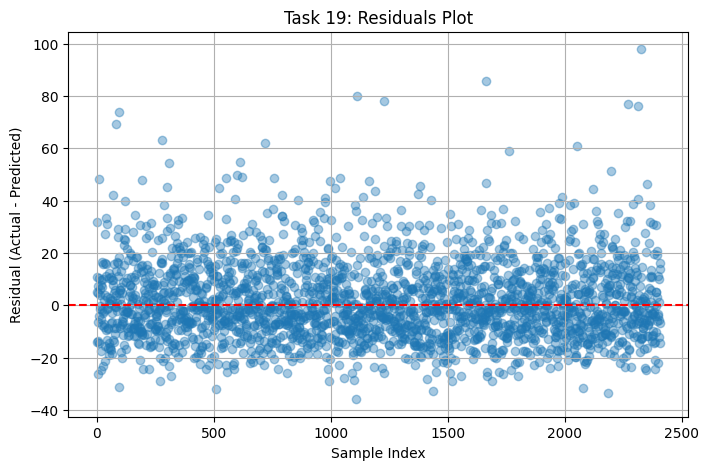

In [51]:
def plot_actual_vs_predicted(y_true, y_pred, task_id):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Processing Time (minutes)')
    plt.ylabel('Predicted Processing Time (minutes)')
    plt.title(f'Task {task_id}: Actual vs Predicted Processing Time')
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, task_id):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(residuals)), residuals, alpha=0.4)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Sample Index')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(f'Task {task_id}: Residuals Plot')
    plt.grid(True)
    plt.show()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true_safe = np.where(y_true == 0, 1e-5, y_true)  # avoid division by zero
    return np.mean(np.abs((y_true_safe - y_pred) / y_true_safe)) * 100

results = []

for idx, task_df in enumerate(task_dataframes, 1):
    print(f"\n=== Task-{idx:02d} ===")

    # Feature Engineering
    df = task_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
    df['minute'] = pd.to_datetime(df['time'], format='%H:%M').dt.minute

    feature_cols = ['year', 'month', 'day', 'weekday', 'hour', 'minute']
    X = df[feature_cols]
    y = df['true_processing_time_minutes'].values

    # Scale Features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42)

    # Print shape before reshape for debugging
    print(f"Shape of X_test before reshape: {X_test.shape}")


    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build Model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')

    # Train Model
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Evaluate Model
    y_pred = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    test_accuracy = 100 - test_mape

    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, Test MAPE: {test_mape:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

    results.append({
        'task_id': f"TASK-{idx:03d}",
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'test_mape': test_mape,
        'test_accuracy': test_accuracy
    })

    # Visualizations
    plot_actual_vs_predicted(y_test, y_pred, idx)
    plot_residuals(y_test, y_pred, idx)

Summarize and Display Results Across All Tasks

In [52]:
results_df = pd.DataFrame(results)
print("\n=== Summary Results Across All Tasks ===")
print(results_df)



=== Summary Results Across All Tasks ===
     task_id        mae       rmse        r2  test_mape  test_accuracy
0   TASK-001   8.198399  10.382911  0.069826  15.065982      84.934018
1   TASK-002  15.624322  20.271291  0.046827  23.597553      76.402447
2   TASK-003  15.437757  19.884653  0.030270  27.759169      72.240831
3   TASK-004   4.292699   5.571171  0.051518  15.881060      84.118940
4   TASK-005   5.322675   6.808722  0.081729  15.420167      84.579833
5   TASK-006  10.830640  14.631500  0.006195  26.457253      73.542747
6   TASK-007   6.214660   8.240689 -0.001919  26.812452      73.187548
7   TASK-008   6.843094   8.946245  0.015579  23.766644      76.233356
8   TASK-009   5.491880   7.137110  0.095815  13.505293      86.494707
9   TASK-010   6.607217   8.908983  0.033710  17.856799      82.143201
10  TASK-011   4.336548   5.604673  0.083149  13.695542      86.304458
11  TASK-012  11.861328  15.711802  0.002901  19.487776      80.512224
12  TASK-013  22.026571  28.936547 

Visualize Actual vs Predicted Processing Time Per Task

In [53]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, task_id):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Processing Time (minutes)')
    plt.ylabel('Predicted Processing Time (minutes)')
    plt.title(f'Task {task_id}: Actual vs Predicted Processing Time')
    plt.grid(True)
    plt.show()


Plot Residuals to Inspect Prediction Errors

In [54]:
def plot_residuals(y_true, y_pred, task_id):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(residuals)), residuals, alpha=0.4)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Sample Index')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title(f'Task {task_id}: Residuals Plot')
    plt.grid(True)
    plt.show()


Calculate Mean Absolute Percentage Error (MAPE) and Accuracy


In [55]:
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true_clip = np.clip(y_true, a_min=1e-5, a_max=None)
    return np.mean(np.abs((y_true_clip - y_pred) / y_true_clip)) * 100

train_mape = mean_absolute_percentage_error(y_train, model.predict(X_train).flatten())
test_mape = mean_absolute_percentage_error(y_test, y_pred)
train_accuracy = 100 - train_mape
test_accuracy = 100 - test_mape

print(f"Task {idx} - Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Task 19 - Train Accuracy: 79.47%, Test Accuracy: 79.57%


 Final Summary Table with Additional Metrics

In [56]:
results.append({
    'task_id': f"TASK-{idx:03d}",
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'test_mape': test_mape,
    'test_accuracy': test_accuracy
})

results_df = pd.DataFrame(results)
print("\n=== Final Summary Results Across All Tasks ===")
print(results_df)




=== Final Summary Results Across All Tasks ===
     task_id        mae       rmse        r2  test_mape  test_accuracy
0   TASK-001   8.198399  10.382911  0.069826  15.065982      84.934018
1   TASK-002  15.624322  20.271291  0.046827  23.597553      76.402447
2   TASK-003  15.437757  19.884653  0.030270  27.759169      72.240831
3   TASK-004   4.292699   5.571171  0.051518  15.881060      84.118940
4   TASK-005   5.322675   6.808722  0.081729  15.420167      84.579833
5   TASK-006  10.830640  14.631500  0.006195  26.457253      73.542747
6   TASK-007   6.214660   8.240689 -0.001919  26.812452      73.187548
7   TASK-008   6.843094   8.946245  0.015579  23.766644      76.233356
8   TASK-009   5.491880   7.137110  0.095815  13.505293      86.494707
9   TASK-010   6.607217   8.908983  0.033710  17.856799      82.143201
10  TASK-011   4.336548   5.604673  0.083149  13.695542      86.304458
11  TASK-012  11.861328  15.711802  0.002901  19.487776      80.512224
12  TASK-013  22.026571  28.9